<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Model-1-:-flop-cards" data-toc-modified-id="Model-1-:-flop-cards-0.1">Model 1 : flop cards</a></span></li><li><span><a href="#Playing-with-threshold" data-toc-modified-id="Playing-with-threshold-0.2">Playing with threshold</a></span></li></ul></li><li><span><a href="#Features-importance-visualization" data-toc-modified-id="Features-importance-visualization-1">Features importance visualization</a></span></li><li><span><a href="#Model-2-:-adding-features" data-toc-modified-id="Model-2-:-adding-features-2">Model 2 : adding features</a></span></li><li><span><a href="#Model-3-:-rank-1,-rank-2-and-rank-3" data-toc-modified-id="Model-3-:-rank-1,-rank-2-and-rank-3-3">Model 3 : rank 1, rank 2 and rank 3</a></span></li><li><span><a href="#Building-the-isomorphic-1755-flops" data-toc-modified-id="Building-the-isomorphic-1755-flops-4">Building the isomorphic 1755 flops</a></span></li></ul></div>

In [1]:
from pathlib import Path
from pokerange import Range
from scipy.stats import linregress

import re

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt

%pylab inline

plt.style.use('fivethirtyeight')

Populating the interactive namespace from numpy and matplotlib


GTO solvers like PioSolver, GTO+, Monkey, SimplePostflop compute complex equilibriums strategies that are not necessary understandable not even less implementable by humans since they have computational limitations.
Due to this limitations, according to Kevin Burns ("Style in Poker", 2006), humans generally "settle for a good enough or *satisficing* strategy".
In other words:
> a reduced rule-set or heuristic that simplifies a player’s mental efforts

So, we are interested here after Ganzfried & Yusuf (2017) for example, in computing strategies thant can be implementred by humans. How we do that?
1. We precomputed mathematical or *optimal* strategies with GTO+ in database mode (1755 flops, the isomorphic ones). It took us 7 hours with a reduced tree: Hero at the BB and Villain at the EP can only bet the *geometric growth of the pot* (GGOP) (Chen & Ankenman). The optimal bet size $B$ in percentage of the pot for 3 streets to come is calculated as following:

\begin{equation*}
B = 
\frac{1}{2}(GGOP-1)
\end{equation*}

\begin{equation*}
GGOP = 
\sqrt[\leftroot{-1}\uproot{2}\scriptstyle 3]{\frac{(2S + P)}{P}}
\end{equation*}


where $P$ is the starting pot amount and $S$ the effective stacks. Since $P = 20.5$ on the flop and $S = 90$, $B=0,5693$.



(By applying LogisticRegression technique to a set of 1755 flops (the isomorphic ones) for which we first compute the optimal strategies with GTO+ software, we will try to create such a reduced rule-set so that humans can apply it during real g. 


In [2]:
import math
#geometric growth of the pot or pot growth rate
ggop=((90*2+20.5)/20.5)**(1/3)

log(200.5/20.5)/log(ggop)

3.0

In [3]:
90*2+20.5

200.5

In [4]:
#ggop * P = P + 2*b
b=(ggop  - 1)*0.5
b

0.5692768793395864

In [5]:
P = 20.5
S=90
for street in range(0,3):
    B=b*P
    P+=(2*B)
    S-=B
    print(B, P, S)

11.67017602646152 43.84035205292304 78.32982397353848
24.957298805836857 93.75494966459675 53.372525167701625
53.37252516770164 200.50000000000003 -1.4210854715202004e-14


In [6]:
P+(0.6463414634146342*P)*2

459.68292682926835

In [7]:
S-(0.6463414634146342*P)

-129.59146341463418

In [8]:
((1170.386634834831 - 20.5)/2)**1/3

191.64777247247184

In [9]:
all_cards = ['2h', '3h', '4h', '5h', '6h', '7h', '8h', '9h', 'Th', 'Jh', 'Qh', 'Kh', 'Ah', 
         '2d', '3d', '4d', '5d', '6d', '7d', '8d', '9d', 'Td', 'Jd', 'Qd', 'Kd', 'Ad', 
         '2c', '3c', '4c', '5c', '6c', '7c', '8c', '9c', 'Tc', 'Jc', 'Qc', 'Kc', 'Ac',
         '2s', '3s', '4s', '5s', '6s', '7s', '8s', '9s', 'Ts', 'Js', 'Qs', 'Ks', 'As']

ranks = ['2','3','4','5','6','7','8','9','T','J','Q','K','A']
suits = ["h", "d", "c","s"]

DATA_DIR = Path.cwd().parent / 'data' 

In [10]:
bb_str = open( DATA_DIR / "01_pk_bb_3br_2020-10-20.txt","r").read()
ep_str = open( DATA_DIR / "02_pk_ep_call3br_2020-10-20.txt","r").read()

In [11]:
bb = Range(bb_str, "BB 3bet range")
ep = Range(ep_str, "EP call to 3bet range")

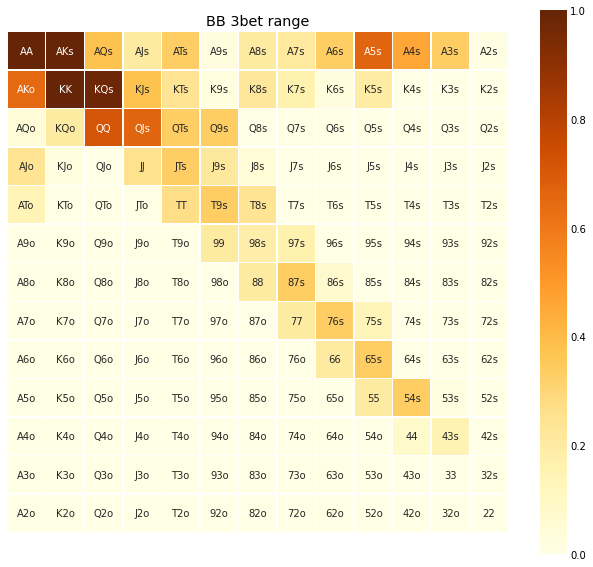

In [12]:
bb.displayRange()

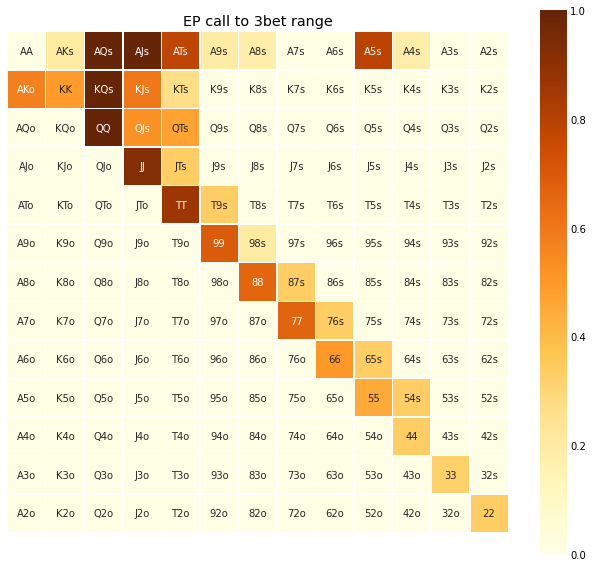

In [13]:
ep.displayRange()

In [14]:
# input : card between 0 and 51
# return rank number [range(0,13)]
def getRank(card):
    return(card%13)

# input : card between 0 and 51
# return suit number [0,1,2,3]
def getSuit(card):
    return(card//13)

def cards_input(cards = None):
    matrix = np.zeros(shape = (4,13), dtype = np.float64)
    if cards is None:
        return matrix
    for i in cards:
        r = getRank(i)
        s = getSuit(i)
        matrix[s][r] = 1.0
    return matrix

crds=cards_input([51,50])
print(crds)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]]


In [15]:
#flops = pd.read_csv("data/csv/upswing_flops.csv",header=0)

In [16]:
# flops = pd.read_csv("data/csv/163flops.txt",header=0)
# flops = pd.read_csv("data/csv/player2.csv",delimiter="\t",header=0, index_col=False)
# flops=flops.set_index('flop').sort_index()
# flops = pd.read_csv("data/csv/_pk_tanagra_output.csv", delimiter=",", header=0, index_col=[0]).sort_index()
# #flops.to_csv("data/csv/_pk_tanagra_output.csv",index=False)
# usecols=range(1,8)
# flops = pd.read_csv("data/csv/01_gto_3bp_player1_bb-vs-btn.csv",\
#                     delimiter="\t", header=0, index_col=[0],usecols=usecols).sort_index()

# col_names=["bet75","bet50","bet33"]
# to_rename=dict()
# for idx, col in enumerate(flops.columns[2:5]):
#     to_rename[col]=col_names[idx]
# flops=flops.rename(columns=to_rename)

In [150]:
cols = ["flops","equity","ev","bet","check"]
#df = pd.read_csv( DATA_DIR / "03_pk_bb-vs-ep_3BP_2020-10-21.txt",delimiter="\t", names=cols, index_col = False)
df = pd.read_csv( DATA_DIR / "04_pk_bb-vs-ep_3BP_2020-11-11.txt",delimiter="\t", names=cols, index_col = False)

flops = df.set_index("flops").sort_index()

In [18]:
flops.head()

,equity,ev,bet,check
flops,,,,
2d2c2h,48.214,10.986,56.517,43.483
3c2d2c,47.744,9.939,56.109,43.891
3d3c2c,48.334,10.447,61.874,38.126
3d3c3h,49.076,11.543,60.937,39.063
3d3h2c,48.017,10.622,58.074,41.926


Text(0.5, 1.0, 'Player 1 - Entire range - 1755 flops')

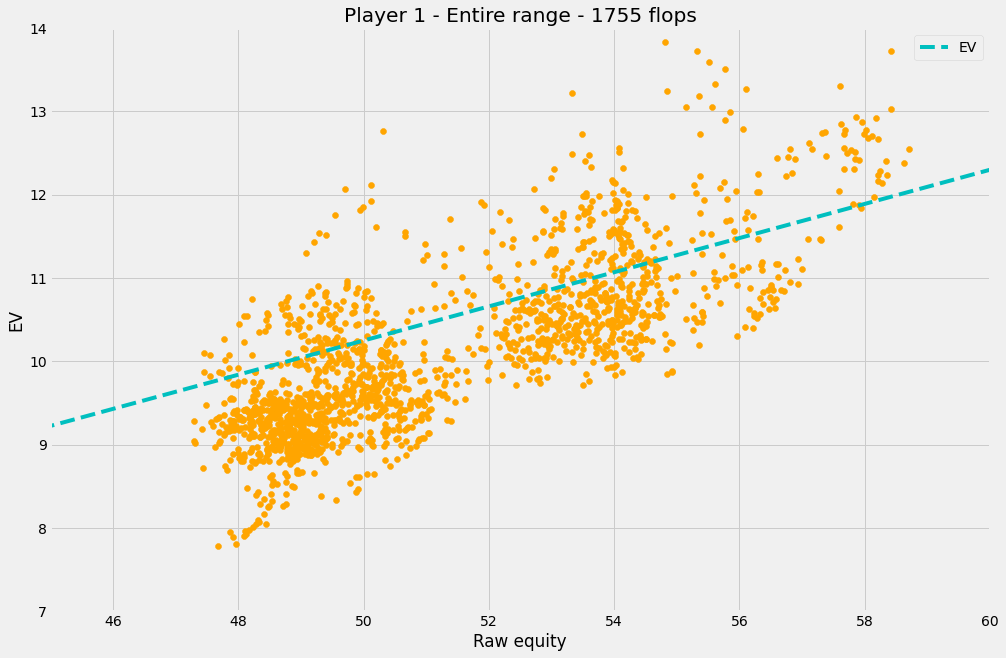

In [85]:
P = 20.5
fig = plt.figure(figsize = (15,10))
ev = [i/100*(P) for i in range(0,100)]
#ev = [i/100*(P - P*0.05) if (P*0.05<2.5) else i/100*(P - 2.5) for i in range(0,100)]
plt.xlim(45,60)
plt.xlabel("Raw equity")
plt.ylabel("EV")
plt.ylim(7,14)
plt.plot(range(0,100),ev, "g--", c ="c", label="EV")
plt.scatter(flops.equity, flops.ev, c="orange")
plt.legend()
plt.title("Player 1 - Entire range - 1755 flops")
#since starting pot = 20.5 we can calculate the ev line before rake
#(amount in bb player 1 should win if he was realizing 100% of his equity)

#ev = [(i - i*0.025) if (i*0.025<2.5) else (i - 2.5) for i in ev]


The figure above shows that some flops, those above the EV line, have a <code>capture factor</code> we call $R$ superior to 1. That means Player 1 can expect to capture in average on later streets a fraction of the pot $P$ such as $EV > E * P$ by a factor equal to $R$.

$EV = E * P * R$

Most of the time Player 1 will not be able to realize 100% of his equity (point belows the dot line), though most of flops give him a range advantage. At first glance, there are three groups of flops, less populated from left to right but we are not interested in clustering them by this way.

As said by Will Tipton:
> That is, $R$ is not only a function of equity. It also depends on things like playability of all the hands in Villain’s range.

In other terms, when $R > 1$, Player's 1 range has a better playability than Villain's range. The purpose of his article is to find, using machine learning techniques, the flop characteristics which are likely to give a better playability to Player 1's range and resume them into simple heuristics easy to apply by a player at a poker table.

R-squared: 0.155819
R-squared: 0.000633


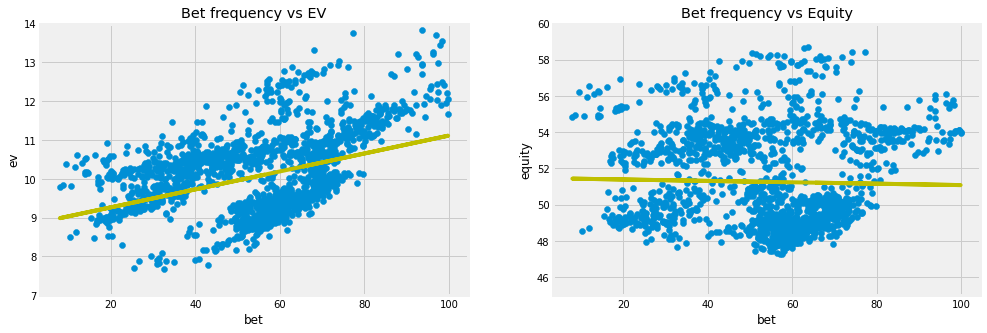

In [20]:
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122,sharex=ax1)
y = flops.ev
ax1.scatter(flops.bet, y)               
ax1.set_title("Bet frequency vs EV")
ax1.set_ylabel("ev")
ax1.set_xlabel("bet")
ax1.set_ylim(7,14)
#ax1.grid(True)
bet_regress = linregress(flops.bet, y)
ax1.plot(flops.bet, flops.bet*bet_regress[0]+bet_regress[1], c = "y")
print("R-squared: %f" % bet_regress[2]**2)

y = flops.equity    
ax2.scatter(flops.bet, y)               
ax2.set_title("Bet frequency vs Equity")        
ax2.set_ylabel("equity")
ax2.set_xlabel("bet")
ax2.set_ylim(45,60)
#ax2.grid(True)
bet_regress = linregress(flops.bet, y)
ax2.plot(flops.bet, flops.bet*bet_regress[0]+bet_regress[1], c = "y")
print("R-squared: %f" % bet_regress[2]**2)

There is clearly a positive correlation between betting frequency and EV, while raw equity on the flop doesn't seem to impact player 1's betting strategy.


Since we search for simple heuristics that an human could memorize and use while playing, we will build our predictive features using only public information shared by both players: the three-cards flop.

Let's now separate flops which allow to realize more than 100% of equity from others.

In [151]:
flops_above_ev = [1 if ev>flops.equity[idx]/100*(P) else 0 for idx, ev in enumerate(flops.ev)]
flops["above_ev"]= flops_above_ev
flops["above_ev"]

flops
2d2c2h    1
3c2d2c    1
3d3c2c    1
3d3c3h    1
3d3h2c    1
         ..
Th9d5c    0
Th9d6c    0
Th9d7c    0
Th9d8c    0
Th9d9c    0
Name: above_ev, Length: 1755, dtype: int64

R-squared: 0.128352
R-squared: 0.002253


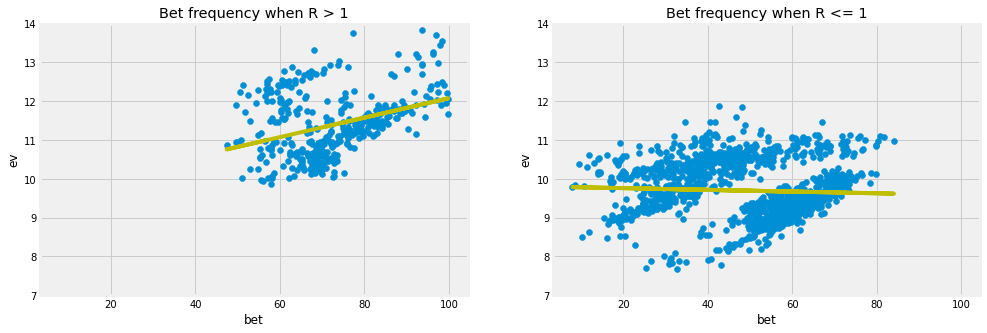

In [22]:
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122,sharex=ax1)
y = flops.ev[flops["above_ev"]==1]
x = flops.bet[flops["above_ev"]==1]
ax1.scatter(x, y)               
ax1.set_title("Bet frequency when R > 1")
ax1.set_ylabel("ev")
ax1.set_xlabel("bet")
ax1.set_ylim(7,14)
#ax1.grid(True)
bet_regress = linregress(x, y)
ax1.plot(x, x*bet_regress[0]+bet_regress[1], c = "y")
print("R-squared: %f" % bet_regress[2]**2)

y = flops.ev[flops["above_ev"]==0]
x = flops.bet[flops["above_ev"]==0]
ax2.scatter(x, y)               
ax2.set_title("Bet frequency when R <= 1")        
ax2.set_ylabel("ev")
ax2.set_xlabel("bet")
ax2.set_ylim(7,14)
#ax2.grid(True)
bet_regress = linregress(x, y)
ax2.plot(x, x*bet_regress[0]+bet_regress[1], c = "y")
print("R-squared: %f" % bet_regress[2]**2)

Pretty clear what happens here! It makes sense since $R$ cannot be superior to $1$ when both players are checking the two remaining streets before going to showdown. In this case, winning hands will have a $R$ equal to $1$ since the amount of the pot at the showdown is the same than on the flop. The only way to have $R>1$ is to bet at least one time and to be called at least one time. This is why Player's is more likely to play more aggressively when the flop is such that it gives a better playability to his range.

Text(0, 0.5, 'ev')

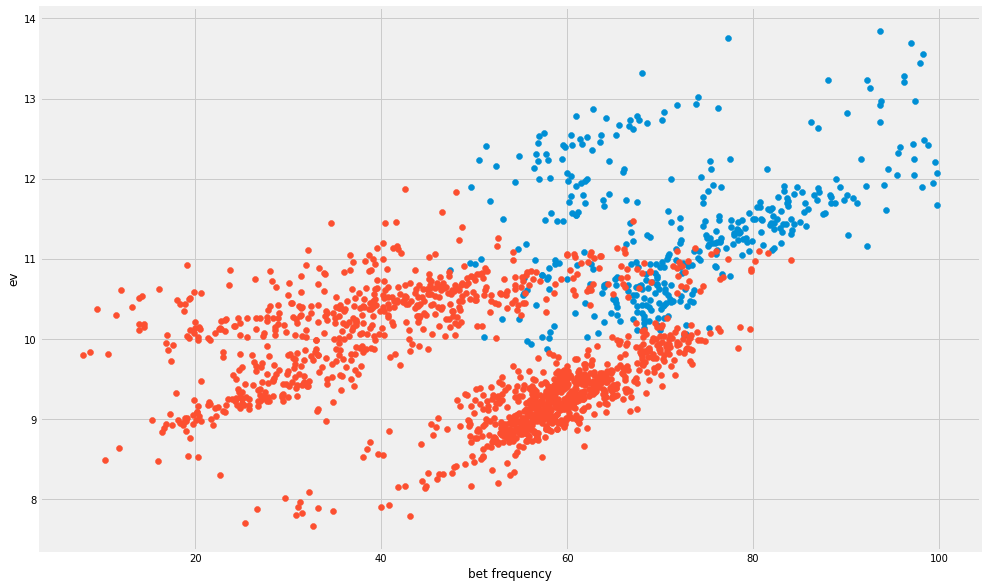

In [23]:
fig = plt.figure(figsize = (15,10))
y1 = flops.ev[flops["above_ev"]==1]
x1 = flops.bet[flops["above_ev"]==1]
plt.scatter(x1, y1)
y2 = flops.ev[flops["above_ev"]==0]
x2 = flops.bet[flops["above_ev"]==0]
plt.scatter(x2, y2)
plt.xlabel("bet frequency")
plt.ylabel("ev")        

### Model 1 : flop cards

In [152]:
#each row is a flop one-hot encoded by his three cards numbers (0 to 51)
x = np.zeros(shape = (len(flops),52), dtype=np.float32)
for flop in range(0, len(flops)):
    idx1,idx2,idx3 = flops.index[flop][0:2],flops.index[flop][2:4],flops.index[flop][4:6]
    #crds=list()
    for idx, card in enumerate(all_cards):
        #print card
        if (idx1 == card) or (idx2 == card) or (idx3 == card):
            x[flop][idx]+=1

In [25]:
#since each row is a flop, if all is all-right, each sum of the row = 3
print(set([i for i in np.sum(x,axis=1)]))

{3.0}


In [153]:
#building ev labels
# y = np.zeros(shape = (len(flops)), dtype=np.float32)
# #mean = flops.ev.mean()
# for idx, i in enumerate(flops.ev):
#     if i > mean:
#         y[idx]+=1
y = flops.above_ev

In [105]:
#x shape has to be equal to y shape
np.shape(x)[0] == np.shape(y)[0]

True

In [28]:
#libraries for maching learning
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.metrics import precision_recall_curve, recall_score, precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler

In [138]:
%%time
w = [{0:1000,1:100},{0:1000,1:10}, {0:1000,1:1.0}, 
     {0:500,1:1.0}, {0:400,1:1.0}, {0:300,1:1.0}, {0:200,1:1.0}, 
     {0:150,1:1.0}, {0:100,1:1.0}, {0:99,1:1.0}, {0:10,1:1.0}, 
     {0:0.01,1:1.0}, {0:0.01,1:10}, {0:0.01,1:100}, 
     {0:0.001,1:1.0}, {0:0.005,1:1.0}, {0:1.0,1:1.0}, 
     {0:1.0,1:0.1}, {0:10,1:0.1}, {0:100,1:0.1}, 
     {0:10,1:0.01}, {0:1.0,1:0.01}, {0:1.0,1:0.001}, {0:1.0,1:0.005}, 
     {0:1.0,1:10}, {0:1.0,1:99}, {0:1.0,1:100}, {0:1.0,1:150}, 
     {0:1.0,1:200}, {0:1.0,1:300},{0:1.0,1:400},{0:1.0,1:500}, 
     {0:1.0,1:1000}, {0:10,1:1000},{0:100,1:1000} ]
crange = np.arange(0.5, 20.0, 0.5)
skf = StratifiedKFold(n_splits=5)
model = LogisticRegressionCV(Cs=crange,random_state=13, cv = skf, scoring = "f1", class_weight=w).fit(x,y)

Wall time: 2.12 s


In [30]:
precision, recall, thresholds = precision_recall_curve(y, model.predict_proba(x)[:,1])
print(precision)
print(recall)
print(thresholds)

[0.2252042  0.2247519  0.22488318 ... 1.         1.         1.        ]
[1.         0.99740933 0.99740933 ... 0.00518135 0.00259067 0.        ]
[2.34626279e-04 2.39435941e-04 2.49108690e-04 ... 9.95949710e-01
 9.96274724e-01 9.99658622e-01]


In [31]:
model.predict_proba(x)[:,1]

array([0.83624981, 0.27787832, 0.26286225, ..., 0.11391788, 0.08916897,
       0.07737925])

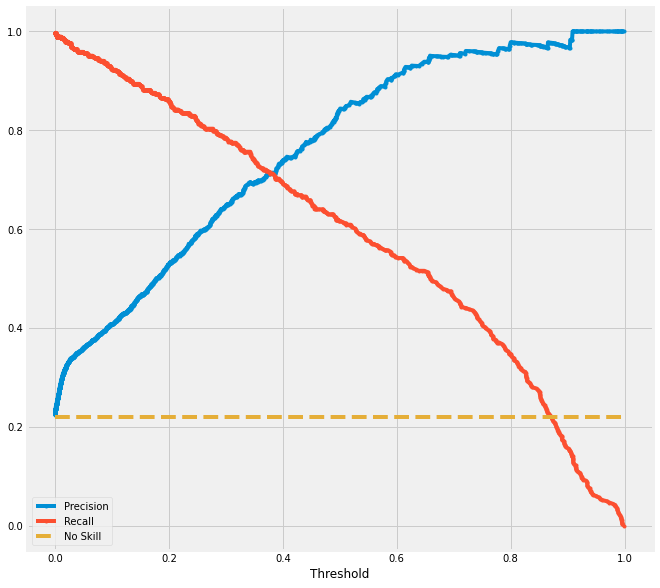

In [32]:
plt.plot(thresholds, precision[1:], marker='.', label='Precision')
plt.plot(thresholds, recall[1:], marker='.', label='Recall')

no_skill = len(y[y==1]) / len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# axis labels
plt.xlabel('Threshold')
#pyplot.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

### Playing with threshold

In [33]:
p = model.predict_proba(x)
# keep probabilities for the positive outcome only
p = p[:, 1]
y_threshold = [1 if i>0.40 else 0 for i in p]
print(classification_report(y, y_threshold))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1369
           1       0.74      0.69      0.71       386

    accuracy                           0.88      1755
   macro avg       0.83      0.81      0.82      1755
weighted avg       0.88      0.88      0.88      1755



In [34]:
classification_report(y, y_threshold,output_dict=True)["1"]

{'precision': 0.7375690607734806,
 'recall': 0.6917098445595855,
 'f1-score': 0.7139037433155081,
 'support': 386}

In [179]:
print(classification_report(y, model.predict(x)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1369
           1       0.91      0.91      0.91       386

    accuracy                           0.96      1755
   macro avg       0.94      0.94      0.94      1755
weighted avg       0.96      0.96      0.96      1755



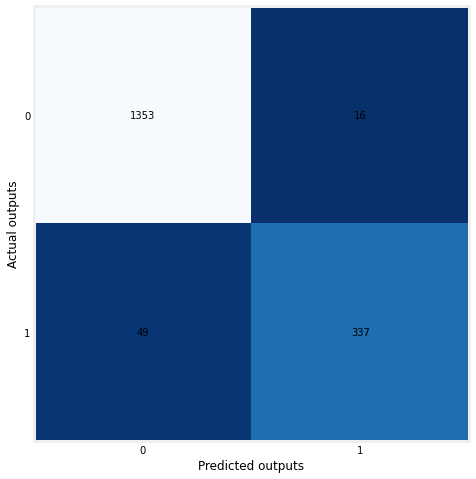

Total positives: 353


In [70]:
cm = confusion_matrix(y, model.predict(x))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm, cmap="Blues_r", interpolation="nearest")
ax.grid(False)
ax.set_xlabel('Predicted outputs', color='black')
ax.set_ylabel('Actual outputs', color='black')
ax.xaxis.set(ticks=range(2))
ax.yaxis.set(ticks=range(2))
#ax.set_ylim(2, -1)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.show()

print(f'Total positives: {np.sum(model.decision_function(x)>0)}')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.988


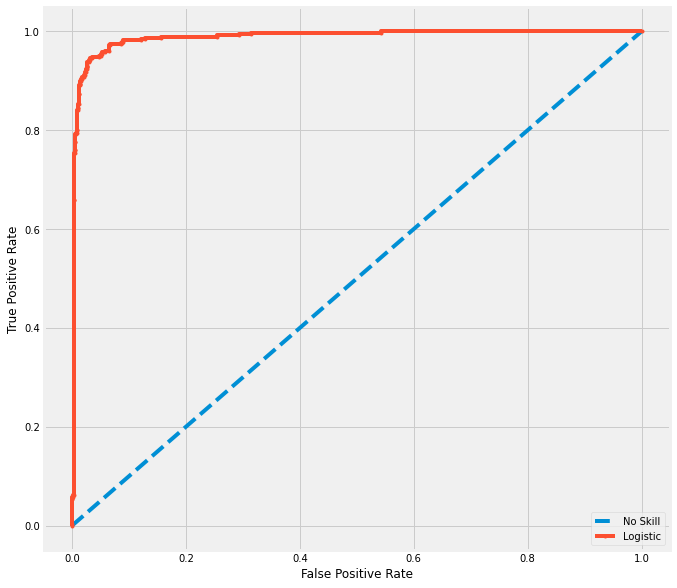

In [71]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y))]

# predict probabilities
lr_probs = model.predict_proba(x)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y, ns_probs)
lr_auc = roc_auc_score(y, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Logistic: f1=0.912 auc=0.950


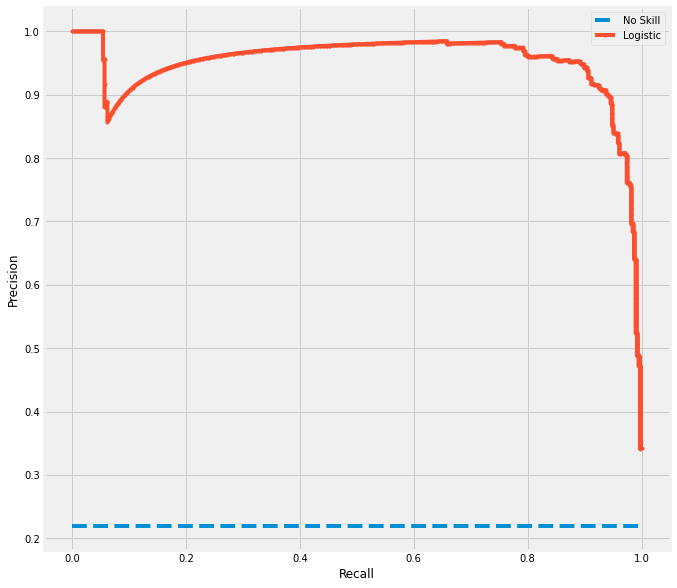

In [72]:
# predict class values
yhat = model.predict(x)
# predict probabilities
lr_probs = model.predict_proba(x)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(y, lr_probs)
lr_f1, lr_auc = f1_score(y, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y[y==1]) / len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [117]:
flops["p_0"]=model.predict_proba(x)[:,0]
flops["p_1"]=model.predict_proba(x)[:,1]
flops["true_p"]=y

In [40]:
flops[flops.above_ev==1].sort_values("ev",ascending=False).head()

,equity,ev,bet,check,above_ev,p_0,p_1,true_p
flops,,,,,,,,
Kh3d3c,54.812,13.837,93.686,6.314,1,0.055136,0.944864,1
AcKdKc,58.425,13.752,77.292,22.708,1,0.006368,0.993632,1
Kh4d4c,55.328,13.691,96.967,3.033,1,0.045363,0.954637,1
Kh6d6c,55.520,13.549,98.330,1.670,1,0.075271,0.924729,1
Kh7d7c,55.761,13.449,97.952,2.048,1,0.171977,0.828023,1


In [41]:
from sklearn.utils.class_weight import compute_class_weight
weighting = compute_class_weight('balanced', [0,1], y)
print(weighting)

[0.64097882 2.27331606]


Text(0.5, 1.0, 'Player 1 - Entire range - 1755 flops')

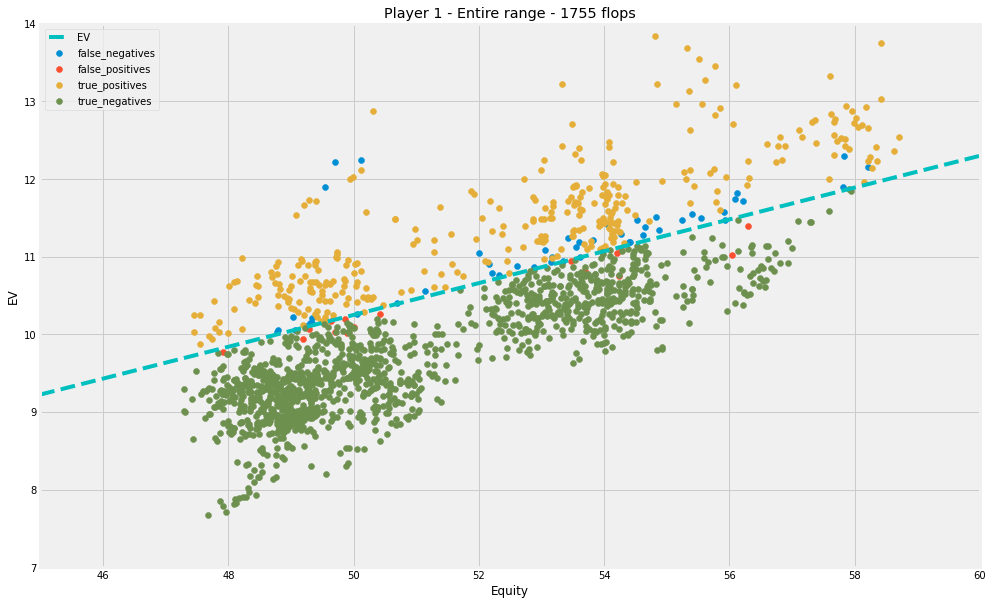

In [75]:
P = 20.5
fig = plt.figure(figsize = (15,10))
ev = [i/100*(P) for i in range(0,100)]
#ev = [i/100*(P - P*0.05) if (P*0.05<2.5) else i/100*(P - 2.5) for i in range(0,100)]
plt.xlim(45,60)
plt.xlabel("Equity")
plt.ylabel("EV")
plt.ylim(7,14)
plt.plot(range(0,100),ev, "g--", c ="c", label="EV")
false_negatives = (flops["p_1"]<=0.5) & (flops["true_p"]==1)
false_positives = (flops["p_1"]>0.5) & (flops["true_p"]==0)
true_positives = (flops["p_1"]>0.5) & (flops["true_p"]==1)
true_negatives = (flops["p_1"]<=0.5) & (flops["true_p"]==0)
plt.scatter(flops.equity[false_negatives], flops.ev[false_negatives], label="false_negatives")
plt.scatter(flops.equity[false_positives], flops.ev[false_positives], label="false_positives")
plt.scatter(flops.equity[true_positives], flops.ev[true_positives], label="true_positives")
plt.scatter(flops.equity[true_negatives], flops.ev[true_negatives], label="true_negatives")        
plt.legend(loc="upper left")
plt.title("Player 1 - Entire range - 1755 flops")

Text(0, 0.5, 'ev')

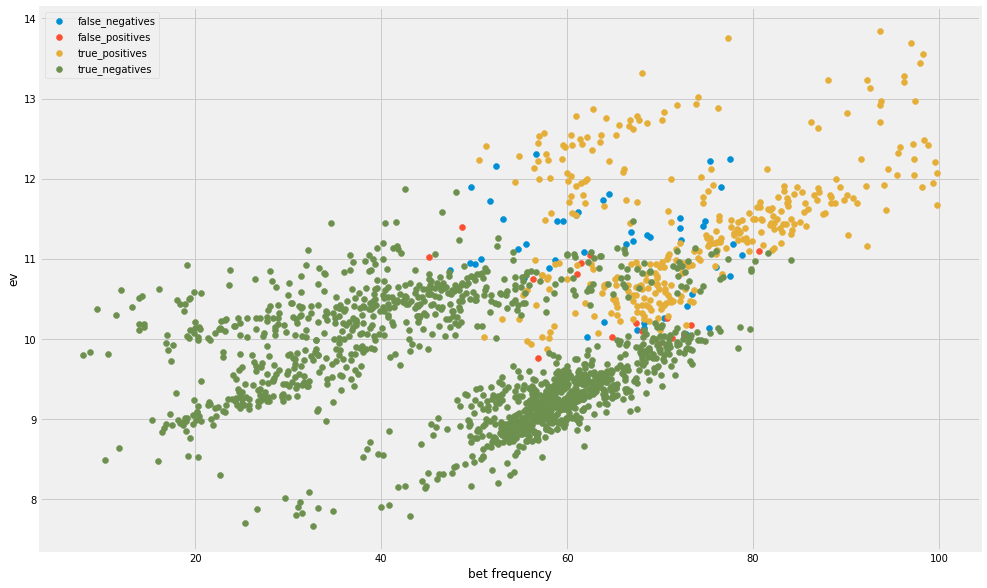

In [76]:
fig = plt.figure(figsize = (15,10))
y1 = flops.ev[false_negatives]
y2 = flops.ev[false_positives]
y3 = flops.ev[true_positives]
y4 = flops.ev[true_negatives]
x1 = flops.bet[false_negatives]
x2 = flops.bet[false_positives]
x3 = flops.bet[true_positives]
x4 = flops.bet[true_negatives]
plt.scatter(x1, y1, label="false_negatives")
plt.scatter(x2, y2, label="false_positives")
plt.scatter(x3, y3, label="true_positives")
plt.scatter(x4, y4, label="true_negatives")
plt.legend(loc="upper left")
plt.xlabel("bet frequency")
plt.ylabel("ev")  

In [44]:
# %%time
# from sklearn.model_selection import GridSearchCV
# # define hyperparameters
# hyperparam_grid = {"class_weight": w
#                    ,"penalty": ["l1", "l2"]
#                    ,"C": crange
#                    ,"fit_intercept": [True, False]  }
# # logistic model classifier
# lg4 = LogisticRegression(random_state=13)# define evaluation procedure
# grid = GridSearchCV(lg4,hyperparam_grid,scoring="precision", cv=100, n_jobs=-1, refit=True)
# grid.fit(x,y)
# print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

In [45]:
#check accuracy
close = np.isclose(model.predict(x),y)
np.sum(close)/1755

0.89002849002849

## Features importance visualization

In [46]:
np.std(x, 0)*model.coef_.ravel()

array([ 0.0313695 ,  0.08458638,  0.06636436,  0.15067103,  0.03736676,
        0.02296171,  0.01006303, -0.03836432, -0.18336434, -0.23581481,
       -0.12542221,  0.49774583, -0.01374151,  0.48488632,  0.49384785,
        0.47108331,  0.29035467,  0.39606533,  0.3270813 ,  0.3104842 ,
        0.31478304, -0.25562584, -0.49422812, -0.02051507,  1.04763126,
        0.38563581, -0.55778464, -0.47849127, -0.32973117, -0.43116665,
       -0.37515618, -0.60088619, -0.68832152, -0.73360519, -1.42855254,
       -1.56362575, -0.79909028,  0.50248598, -0.1721374 ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [184]:
c = np.std(x, 0)*model.coef_.ravel()
coefs = np.zeros(shape=(1,len(x.columns)))
for idx, i in enumerate(c):
    coefs[0][idx]+=i
np.shape(model.coef_)

if np.shape(x)[1]>52:
    coef2_ = coefs[:,52:]
    coef1_ = coefs[:,0:52]
elif np.shape(x)[1]<52:
    coef1_ = None
    coef2_ = coefs
else:
    coef2_ = None
    coef1_ = coefs 

In [185]:
if coef1_ is not None:
    coeffs_by_rank = np.zeros(shape=(1,13), dtype = np.float64)
    for i in range(0,52):
        j= getRank(i)
        val = coef1_[0][i]
        coeffs_by_rank[0][j]+=val
    coeffs_by_rank = coeffs_by_rank / 4
else:
    pass

C:\Users\Wilfrid\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:2260: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


'Score: 0.91'

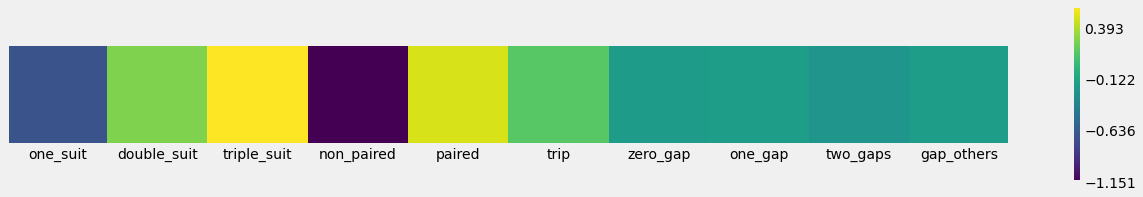

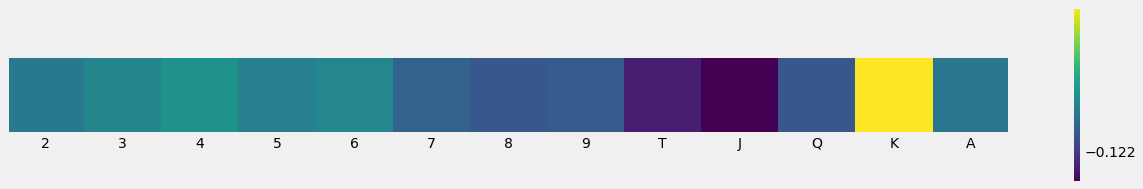

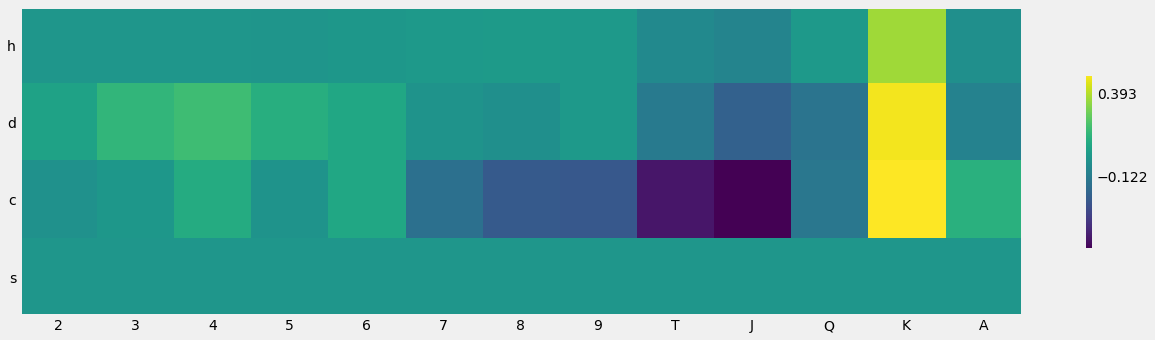

In [186]:
plt.style.use('fivethirtyeight')
display("Score: " + str(round(model.score(x, y),2)))

if coef2_ is not None:
    fig, ax = plt.subplots(1,1, figsize=(20,10))
    plt.xticks(range(0,len(x.columns[52:62])), x.columns[52:62])
    plt.yticks([])
    plt.imshow(coef2_[:,:10],interpolation='nearest')
    bins = np.linspace(coefs.min(),coefs.max(), 5)
    plt.colorbar(shrink=.3, ticks=bins)
    plt.grid(False)
    
if coef1_ is not None:
    fig, ax = plt.subplots(1,1, figsize=(20,10))
    plt.xticks(range(13), ranks)
    plt.yticks([])
    plt.imshow(coeffs_by_rank,interpolation='nearest')
    bins = np.linspace(coefs.min(), coefs.max(), 5)
    plt.colorbar(shrink=.3, ticks=bins)
    plt.grid(False)
    
if coef1_ is not None:
    coefs_=np.zeros(shape=(4,13), dtype = np.float64)
    for i in range(0,52):
        rank = getRank(i)
        suit = getSuit(i)
        val = coef1_ [0][i]
        coefs_[suit][rank]+=val
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(1,1, figsize=(20,10))
    plt.yticks(range(4), suits)
    plt.xticks(range(13), ranks)
    img = ax.imshow(coefs_,interpolation='nearest')
    bins = np.linspace(coefs.min(), coefs.max(), 5)
    plt.colorbar(img, shrink=.3, ticks=bins)
    plt.grid(False)

plt.show()

In [187]:
pd.DataFrame(coeffs_by_rank.ravel(),index=ranks,columns=["coef"]).sort_values("coef",ascending=False)

,coef
K,0.342059
4,0.068356
6,0.039422
3,0.036880
5,0.024343
2,0.007836
A,-0.000165
7,-0.041298
9,-0.059532
8,-0.066771


In [188]:
#ranks x.columns[52:]
ranks_df = pd.DataFrame(coeffs_by_rank.ravel(),index=ranks,columns=["coef"])
features_df = pd.DataFrame(coef2_.ravel(),index=x.columns[52:],columns=["coef"])
frames = [ranks_df, features_df]
all_features_df = pd.concat(frames)
all_features_df.sort_values("coef",ascending=False)

,coef
r1_K,0.907519
r2_K,0.618435
triple_suit,0.601521
paired,0.494529
K,0.342059
...,...
r1_J,-0.361248
r1_T,-0.362056
r2_J,-0.407798
one_suit,-0.703227


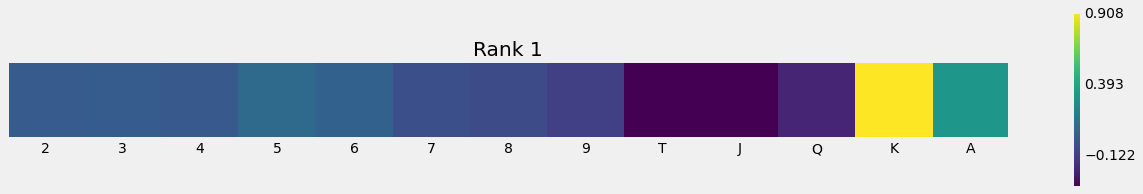

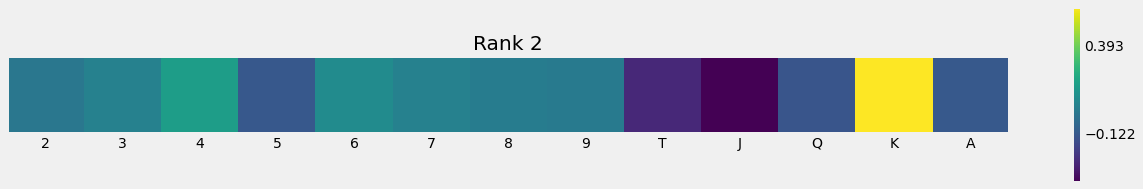

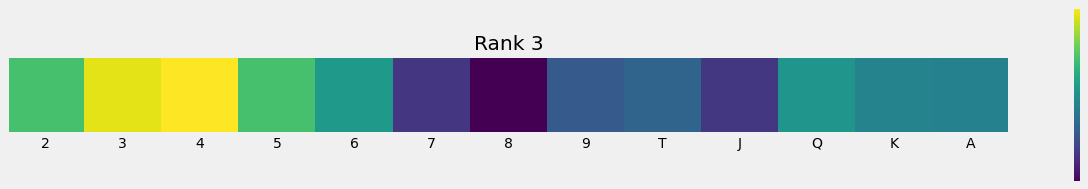

In [189]:
#rank1 = coef1_[62:75]
rr1 = np.zeros(shape=(1,13), dtype = np.float64)
for idx, i in enumerate(coefs[0][62:75]):   
    rr1[0][idx]+=i
fig, ax = plt.subplots(1,1, figsize=(20,10))
plt.xticks(range(13), ranks)
plt.yticks([])
plt.imshow(rr1,interpolation='nearest')
bins = np.linspace(coefs.min(), coefs.max(), 5)
plt.colorbar(shrink=.3, ticks=bins)
plt.title("Rank 1")
plt.grid(False)
rr2 = np.zeros(shape=(1,13), dtype = np.float64)
for idx, i in enumerate(coefs[0][75:88]):   
    rr2[0][idx]+=i
fig, ax = plt.subplots(1,1, figsize=(20,10))
plt.xticks(range(13), ranks)
plt.yticks([])
plt.imshow(rr2,interpolation='nearest')
bins = np.linspace(coefs.min(), coefs.max(), 5)
plt.colorbar(shrink=.3, ticks=bins)
plt.title("Rank 2")
plt.grid(False)
rr3 = np.zeros(shape=(1,13), dtype = np.float64)
for idx, i in enumerate(coefs[0][88:101]):   
    rr3[0][idx]+=i
fig, ax = plt.subplots(1,1, figsize=(20,10))
plt.xticks(range(13), ranks)
plt.yticks([])
plt.imshow(rr3,interpolation='nearest')
bins = np.linspace(coefs.min(), coefs.max(), 5)
plt.colorbar(shrink=.3, ticks=bins)
plt.title("Rank 3")
plt.grid(False)

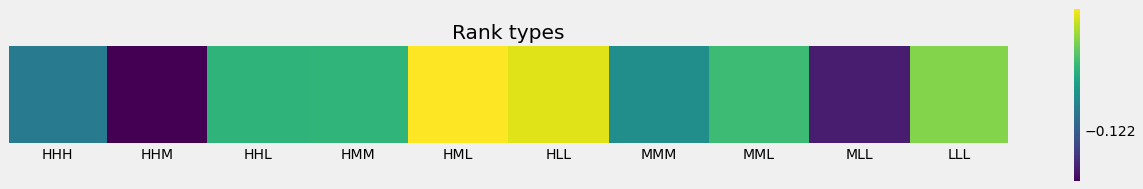

In [146]:
rr4 = np.zeros(shape=(1,10), dtype = np.float64)
for idx, i in enumerate(coefs[0][101:]):   
    rr4[0][idx]+=i
fig, ax = plt.subplots(1,1, figsize=(20,10))
plt.xticks(range(0,len(x.columns[101:])), x.columns[101:])
plt.yticks([])
plt.imshow(rr4,interpolation='nearest')
bins = np.linspace(coefs.min(),coefs.max(), 5)
plt.colorbar(shrink=.3, ticks=bins)
plt.title("Rank types")
plt.grid(False)

In [148]:
#saving the model
from joblib import dump, load
dump(model, DATA_DIR / "model.joblib") 

model2 = load(DATA_DIR / "model.joblib")



In [ ]:
#np.sum(x*coefs[0,:]+model.intercept_[0],axis=1).sort_values(ascending=False)

## Model 2 : adding features

In [ ]:
# model.coef_

In [155]:
suited=[]
for f in flops.index: 
    s = set([i for i in f if i in suits])
    suited.append(len(s))


In [156]:
flops["one_suit"]=[1 if i == 1 else 0 for i in suited]
flops["double_suit"]=[1 if i == 2 else 0 for i in suited]
flops["triple_suit"]=[1 if i == 3 else 0 for i in suited]

In [157]:
kind=[]
for f in flops.index: 
    r = set([i for i in f if i in ranks])
    kind.append(len(r))

In [158]:
flops["non_paired"]=[1 if i == 3 else 0 for i in kind]
flops["paired"]=[1 if i == 2 else 0 for i in kind]
flops["trip"]=[1 if i == 1 else 0 for i in kind]

In [159]:
zero_gap=[]
for i in range(0,11):
    zero_gap.append([i,i+1,i+2][::-1])
zero_gap.append([12,1,0])
zero_gap

[[2, 1, 0],
 [3, 2, 1],
 [4, 3, 2],
 [5, 4, 3],
 [6, 5, 4],
 [7, 6, 5],
 [8, 7, 6],
 [9, 8, 7],
 [10, 9, 8],
 [11, 10, 9],
 [12, 11, 10],
 [12, 1, 0]]

In [160]:
gap=[]
for f in flops.index: 
    r = [i for i in f if i in ranks]
    r_idx = [ranks.index(i) for i in r if i in ranks]    
    if r_idx in zero_gap:
        gap.append(1)
    else:
        gap.append(0)

In [161]:
flops["zero_gap"]=gap
flops[flops["zero_gap"]==1].head()

,equity,ev,bet,check,above_ev,one_suit,double_suit,triple_suit,non_paired,paired,trip,zero_gap
flops,,,,,,,,,,,,
4c3c2c,49.233,9.338,25.067,74.933,0,1,0,0,1,0,0,1
4c3c2d,48.529,9.266,64.791,35.209,0,0,1,0,1,0,0,1
4c3d2c,48.562,9.297,64.934,35.066,0,0,1,0,1,0,0,1
4d3c2c,48.559,9.279,64.789,35.211,0,0,1,0,1,0,0,1
4h3d2c,48.191,9.290,62.303,37.697,0,0,0,1,1,0,0,1


In [162]:
one_gap=[]
for i in range(0,10):
    one_gap.append([i,i+1,i+3][::-1])
    one_gap.append([i,i+2,i+3][::-1])
one_gap.append([12,2,0])
one_gap.append([12,2,1])
# for g in one_gap:
#     print(ranks[g[0]], ranks[g[1]], ranks[g[2]])
gap=[]
for f in flops.index: 
    r = [i for i in f if i in ranks]
    r_idx = [ranks.index(i) for i in r if i in ranks]    
    if r_idx in one_gap:
        gap.append(1)
    else:
        gap.append(0)
flops["one_gap"]=gap
two_gaps=[]
for i in range(0,9):
    two_gaps.append([i,i+2,i+4][::-1])
    two_gaps.append([i,i+3,i+4][::-1])
    two_gaps.append([i,i+1,i+4][::-1])
two_gaps.append([12,3,0])
two_gaps.append([12,3,1])
# for g in two_gaps:
#     print(ranks[g[0]], ranks[g[1]], ranks[g[2]])
gap=[]
for f in flops.index: 
    r = [i for i in f if i in ranks]
    r_idx = [ranks.index(i) for i in r if i in ranks]    
    if r_idx in two_gaps:
        gap.append(1)
    else:
        gap.append(0)
flops["two_gaps"]=gap
gap=[]
for f in flops.index: 
    r = [i for i in f if i in ranks]
    r_idx = [ranks.index(i) for i in r if i in ranks]    
    if r_idx not in two_gaps and r_idx not in one_gap and r_idx not in zero_gap and len(set(r))==3:
        gap.append(1)
    else:
        gap.append(0)
flops["gap_others"]=gap

In [163]:
# from itertools import permutations, product, combinations
# [i for i in combinations(["1","2","3","4","5"], r=3)]

In [167]:
#each row is a flop one-hot encoded by his three cards numbers (0 to 51)
features = np.zeros(shape = (len(flops),52), dtype=np.float32)
for flop in range(0, len(flops)):
    idx1,idx2,idx3 = flops.index[flop][0:2],flops.index[flop][2:4],flops.index[flop][4:6]
    #crds=list()
    for idx, card in enumerate(all_cards):
        #print card
        if (idx1 == card) or (idx2 == card) or (idx3 == card):
            features[flop][idx]+=1
df_features = pd.DataFrame(features, dtype=np.float,index=flops.index)
x = df_features.join(flops.drop(['equity','ev','bet','check','above_ev','p_0','p_1','true_p'],axis=1))

In [168]:
x.shape

(1755, 62)

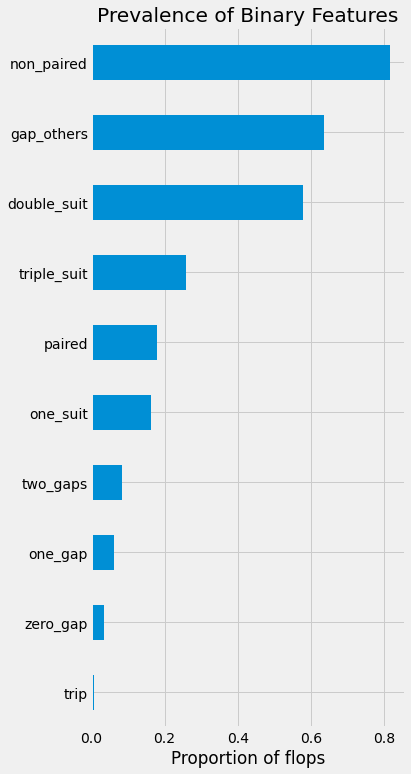

In [169]:
sorted_binary_features = x.iloc[:, 52:].mean().sort_values()
ax = sorted_binary_features.plot(kind='barh',
                                 stacked=True,
                                 figsize=(5, 12),
                                 title='Prevalence of Binary Features')
ax.set_xlabel('Proportion of flops');

## Model 3 : rank 1, rank 2 and rank 3 

In [170]:
#each row is a flop one-hot encoded by his three cards numbers (0 to 51)
rr = np.zeros(shape = (len(flops),39), dtype=np.float32)
for idx, f in enumerate(df_features.index): 
    rks = [getRank(ix) for ix, i in enumerate(df_features.loc[f]) if i==1]
    rks = sort(rks)[::-1]    
    rr[idx][rks[0]]+=1
    rr[idx][rks[1]+13]+=1
    rr[idx][rks[2]+26]+=1

cols=[]
for i in range(1,4):
    for j in range(0,13):
        col = "r"+str(i)+"_"+ranks[j]
        cols.append(col)
rr_features=pd.DataFrame(rr, dtype=np.float,index=flops.index,columns=cols)
x = x.join(rr_features)

In [171]:
x.shape

(1755, 101)

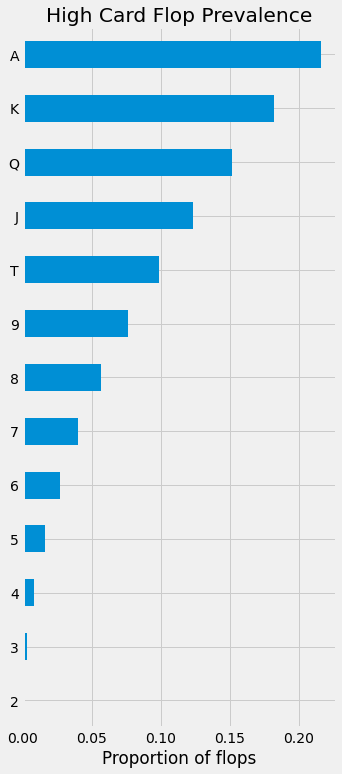

In [172]:
sorted_binary_features = x.iloc[:, 62:75].mean().sort_values()
ax = sorted_binary_features.plot(kind='barh',
                                 stacked=True,
                                 figsize=(5, 12),
                                 title='High Card Flop Prevalence')
ax.set_xlabel('Proportion of flops')
ax.set_yticks(range(0,13))
ax.set_yticklabels(ranks)
plt.show()

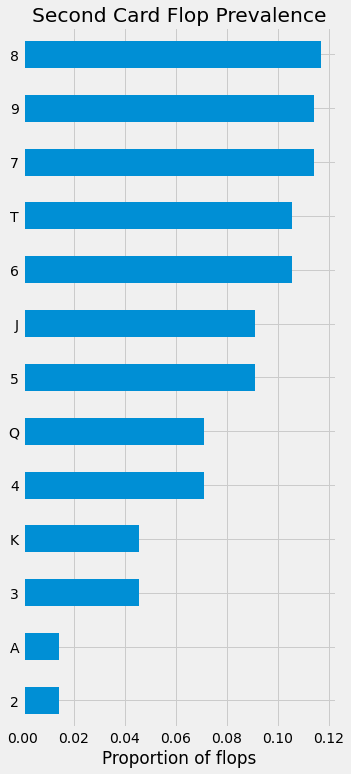

In [173]:
sorted_binary_features = x.iloc[:, 75:88].mean().sort_values()
ax = sorted_binary_features.plot(kind='barh',
                                 stacked=True,
                                 figsize=(5, 12),
                                 title='Second Card Flop Prevalence')
ax.set_xlabel('Proportion of flops')
ax.set_yticks(range(0,13))
ax.set_yticklabels(sorted_binary_features.index.str.replace("r2_",""))
plt.show()

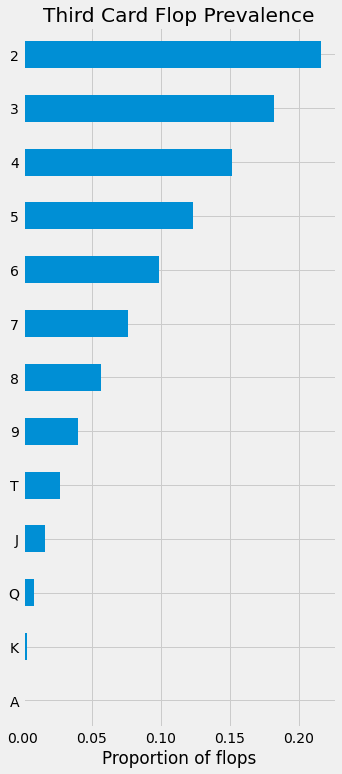

In [174]:
sorted_binary_features = x.iloc[:, 88:].mean().sort_values()
ax = sorted_binary_features.plot(kind='barh',
                                 stacked=True,
                                 figsize=(5, 12),
                                 title='Third Card Flop Prevalence')
ax.set_xlabel('Proportion of flops')
ax.set_yticks(range(0,13))
ax.set_yticklabels(sorted_binary_features.index.str.replace("r3_",""))
plt.show()

In [176]:
rank_types = ['HHH','HHM','HHL','HMM','HML','HLL','MMM','MML','MLL','LLL']
rr_type = np.zeros(shape = (len(flops),10), dtype=np.float32)
for idx, f in enumerate(flops.index): 
    r = [i for i in f if i in ranks]
    r_idx = [ranks.index(i) for i in r if i in ranks]
    _str=""
    for rk in r_idx:
        if rk>=8:
            _str+="H"
        elif rk<8 and rk>3:
            _str+="M"
        else:
            _str+="L"     
    for rt, i in enumerate(rank_types):        
        if i == _str:
            rr_type[idx][rt]+=1      

rr_type_features=pd.DataFrame(rr_type, dtype=np.float,index=flops.index,columns=rank_types)
x = x.join(rr_type_features)

ValueError: columns overlap but no suffix specified: Index(['HHH', 'HHM', 'HHL', 'HMM', 'HML', 'HLL', 'MMM', 'MML', 'MLL', 'LLL'], dtype='object')

In [177]:
x.shape

(1755, 111)

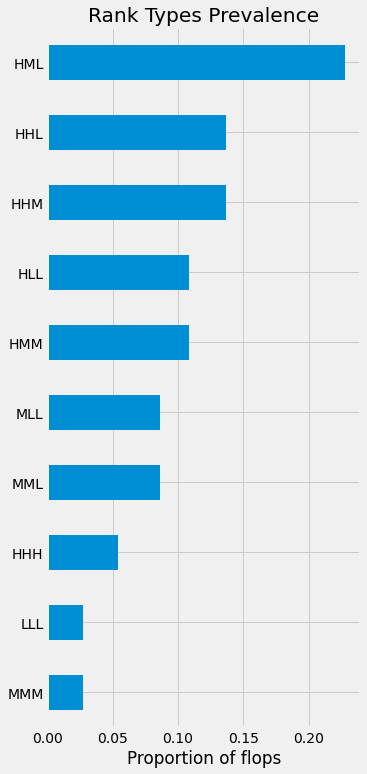

In [178]:
sorted_binary_features = x.iloc[:, 101:].mean().sort_values()
ax = sorted_binary_features.plot(kind='barh',
                                 stacked=True,
                                 figsize=(5, 12),
                                 title='Rank Types Prevalence')
ax.set_xlabel('Proportion of flops')
ax.set_yticks(range(0,10))
ax.set_yticklabels(sorted_binary_features.index)
plt.show()

## Building the isomorphic 1755 flops

In [ ]:
from itertools import combinations, permutations, product
al_flops = [''.join(combination) for combination in combinations(all_cards, r=3)]

In [ ]:
len(al_flops)

In [ ]:
all_flops = list()
for f in al_flops:
    r = [i for i in f if i in ranks]
    s = [i for i in f if i in suits]
    r_idx = np.array([ranks.index(i) for i in r if i in ranks]) 
    idx= np.argsort(r_idx)[::-1]    
    flop = r[idx[0]] + s[idx[0]] + r[idx[1]] + s[idx[1]] + r[idx[2]] + s[idx[2]] 
    all_flops.append(flop)
        
    

In [ ]:
final_set = set()

In [ ]:
#non-paired flop and single suit
c = 0
#final_set = set()
to_remove=list()
for idx, f in enumerate(all_flops):
    s = set([i for i in f if i in suits])
    if len(s)==1:
        c+=1
        iso = f.replace(list(s)[0],"h")
        final_set.add(iso)
        to_remove.append(idx)
all_flops = [i for idx, i in enumerate(all_flops) if idx not in to_remove]
print(c)
print(len(all_flops))
print(len(final_set)) #good

In [ ]:
1144/286

In [ ]:
#non-paired flop and double suit
c = 0
to_remove=list()
for idx, f in enumerate(all_flops):
    r = [i for i in f if i in ranks]  
    s = [i for i in f if i in suits]
    
    if len(set(r))==3 and len(set(s))==2:
        c+=1
        if s[0] == s[1]:
            iso = r[0] + "h" + r[1] + "h" + r[2] + "d"
        if s[0] == s[2]:
            iso = r[0] + "h" + r[1] + "d" + r[2] + "h"
        if s[1] == s[2]:
            iso = r[0] + "h" + r[1] + "d" + r[2] + "d"            
        final_set.add(iso)
        to_remove.append(idx)
all_flops = [i for idx, i in enumerate(all_flops) if idx not in to_remove]
print(c)
print(len(all_flops))
print(len(final_set)) #good 

In [ ]:
#non-paired flop and triple suit
c = 0
to_remove=list()
for idx, f in enumerate(all_flops):
    r = [i for i in f if i in ranks]
    s = [i for i in f if i in suits]
   
    if len(set(s))==3 and len(set(r))==3:
        c+=1        
        iso = r[0] + "h" + r[1] +"d" + r[2] + "c"      
        final_set.add(iso)
        to_remove.append(idx)
all_flops = [i for idx, i in enumerate(all_flops) if idx not in to_remove]
print(c)
print(len(all_flops))
print(len(final_set))

In [ ]:
#trips
c = 0
to_remove=list()
for idx, f in enumerate(all_flops):
    r = [i for i in f if i in ranks]
    #s = set([i for i in f if i in suits])
   
    if len(set(r))==1:
        c+=1               
        iso = r[0] + "h" + r[0] +"d" + r[0] + "c"      
        final_set.add(iso)
        to_remove.append(idx)
all_flops = [i for idx, i in enumerate(all_flops) if idx not in to_remove]
print(c)
print(len(all_flops))
print(len(final_set))#good

In [ ]:
#paired flops and triple suit
c = 0
to_remove=list()
for idx, f in enumerate(all_flops):
    r = [i for i in f if i in ranks]
    s = [i for i in f if i in suits]
   
    if len(set(r))==2 and len(set(s))==3:
        c+=1               
        iso = r[0] + "h" + r[1] + "d" + r[2] + "c"      
        final_set.add(iso)
        to_remove.append(idx)
all_flops = [i for idx, i in enumerate(all_flops) if idx not in to_remove]
print(c)
print(len(all_flops))
print(len(final_set)) #good

In [ ]:
#paired flops and double suit
c = 0
to_remove=list()
for idx, f in enumerate(all_flops):
    r = [i for i in f if i in ranks]
    s = [i for i in f if i in suits]
   
    if len(set(r))==2 and len(set(s))==2:
        c+=1        
        if r[0]== r[1]:
            iso = r[0] + "h" + r[1] + "d" + r[2] + "d"
        if r[1]== r[2]:
            iso = r[0] + "h" + r[1] + "h" + r[2] + "d"
        #if s[1]== s[2]:
            #iso = r[0] + "h" + r[1] + "d" + r[2] + "d"            
        final_set.add(iso)
        to_remove.append(idx)
all_flops = [i for idx, i in enumerate(all_flops) if idx not in to_remove]
print(c)
print(len(all_flops))
print(len(final_set)) #wrong

In [ ]:
1144/22100 == 286/1755

In [ ]:
c=0
for f in list(final_set):    
    r = [i for i in f if i in ranks]
    s = [i for i in f if i in suits]
    if r[0]=="A" and r[1]=="K" and len(set(s))==2:
        print(f)
        c+=1
print(c)

In [ ]:
[''.join(combination) for combination in combinations(suits, r=3)]

In [ ]:
[''.join(combination) for combination in combinations(suits, r=2)]

In [ ]:
[''.join(combination) for combination in product(suits, repeat=2)]

In [ ]:
r = [1,2,3]
if len(set(r))==3:
    r1, r2, r3 = r[0], r[1], r[2]
    print(r1)
    print(r2)
    print(r3)